In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
baseball_df = pd.read_csv('~/Documents/IN4027/Data/baseball.csv')
baseball_df.head()

,Player,MLE,TRUTH
0,1,0.345,0.298
1,2,0.333,0.346
2,3,0.322,0.222
3,4,0.311,0.276
4,5,0.289,0.263


#### We suppose that number of hits for player i $h_i \sim Bin(90, \pi_i)$.
#### Thus, each player's batting average $p_i \sim Bin(90, \pi_i)/90$, where $\pi_i$ is its true average.
#### MLE column represents MLE estimate of $p_i$ (mean proportion) of first 90 at bats

In [3]:
# Using Normal Approximation...
# Get binomial variance
baseball_df['pi_90'] = baseball_df['MLE']
p_bar = baseball_df['pi_90'].mean()
p_variance = p_bar * (1- p_bar) / 90
# Transform to N(mu, 1) distr.
baseball_df['x_norm'] = baseball_df['pi_90'] / np.sqrt(p_variance)
# Get sum of squares of pi vs p_bar
ssq_pi = np.sum((baseball_df['pi_90'] - p_bar) ** 2)
baseball_df['p_hat_JS'] = p_bar + (1 - (18 - 3) * p_variance / ssq_pi) * (baseball_df['pi_90'] - p_bar)

In [4]:
baseball_df[['MLE', 'p_hat_JS', 'TRUTH', 'x_norm']]

,MLE,p_hat_JS,TRUTH,x_norm
0,0.345,0.284893,0.298,7.522698
1,0.333,0.280786,0.346,7.261039
2,0.322,0.277021,0.222,7.021185
3,0.311,0.273255,0.276,6.781331
4,0.289,0.265725,0.263,6.301622
5,0.289,0.265725,0.273,6.301622
6,0.278,0.261959,0.303,6.061768
7,0.255,0.254087,0.270,5.560255
8,0.244,0.250321,0.230,5.320401
9,0.233,0.246556,0.264,5.080547


In [5]:
# Now compute Sum of Squared Errors for both MLE and JS
(((baseball_df['MLE'] - baseball_df['TRUTH']) ** 2).sum(), 
((baseball_df['p_hat_JS'] - baseball_df['TRUTH']) ** 2).sum())

(0.04251199999999998, 0.02125445075434289)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


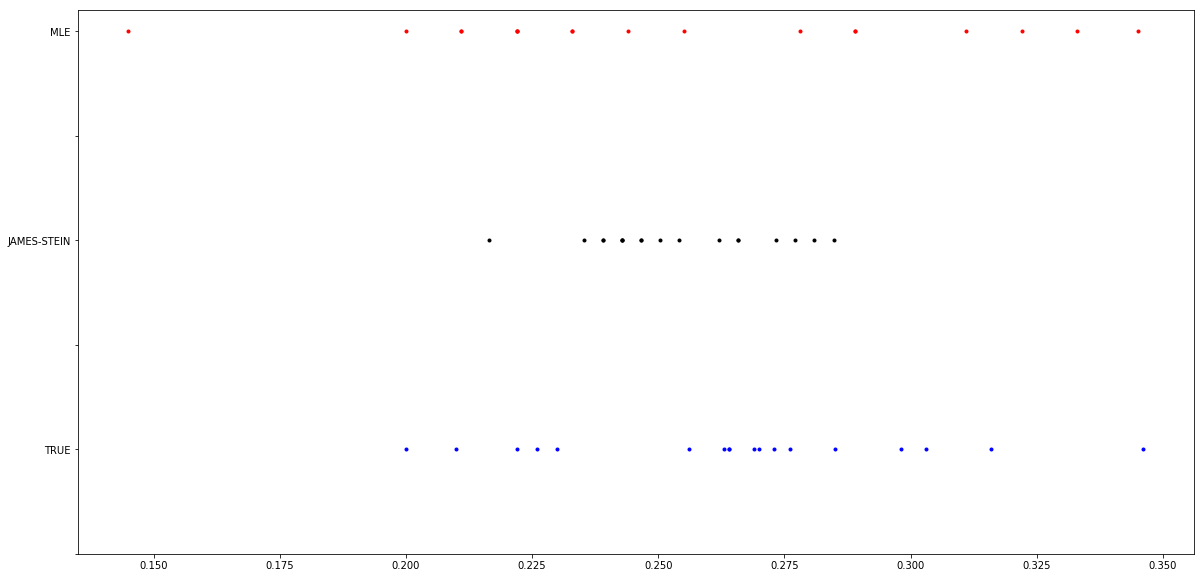

In [6]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.plot(baseball_df['MLE'], np.repeat(5,baseball_df.shape[0]), '.r')
ax.plot(baseball_df['p_hat_JS'], np.repeat(3,baseball_df.shape[0]), '.k')
ax.plot(baseball_df['TRUTH'], np.repeat(1,baseball_df.shape[0]), '.b')
ax.set_yticks(np.arange(6))
ax.set_yticklabels(('','TRUE', '', 'JAMES-STEIN', '', 'MLE'))
fig.show()

In [7]:
def JS_estimator(df):
    p_bar = df['avg_sim'].mean()
    p_variance = p_bar * (1- p_bar) / 90
    # Transform to N(mu, 1) distr.
    df['x_norm'] = df['avg_sim'] / np.sqrt(p_variance)
    # Get sum of squares of pi vs p_bar
    ssq_pi = np.sum((df['avg_sim'] - p_bar) ** 2)
    df['p_hat_JS'] = p_bar + (1 - (18 - 3) * p_variance / ssq_pi) * (df['avg_sim'] - p_bar)
    df['p_hat_JS1'] = np.minimum(np.maximum(df['p_hat_JS'], df['avg_sim'] - np.sqrt(p_variance)),
                                df['avg_sim'] + np.sqrt(p_variance))
    
    return df['p_hat_JS'].values, df['p_hat_JS1'].values

In [8]:
# Now, let's run 5000 simulations of each player using a Bin(90, truth) / 90 distribution.
df_sims = pd.DataFrame({'player':[], 'avg_sim':[]})
df_work = pd.DataFrame({'player':[], 'avg_sim':[]})
truth_values = list(baseball_df['TRUTH'])

for it in range(1,5000):
    df_work['avg_sim'] = st.binom.rvs(90, truth_values, size=18) / 90
    df_work['rep_numb'] = it
    df_work['sqerrMLE'] = (df_work['avg_sim'] - truth_values) ** 2
    df_work['p_hat_JS'], df_work['p_hat_JS1'] = JS_estimator(df_work)
    df_work['sqerrJS'] = (df_work['p_hat_JS'] - truth_values) ** 2
    df_work['sqerrJS1'] = (df_work['p_hat_JS1'] - truth_values) ** 2
    df_work['player'] = np.linspace(1,18,18)
    df_sims = pd.concat([df_sims, df_work], sort=False)

In [9]:
df_summ = df_sims.groupby('player').mean().reset_index()
df_summ['TRUTH'] = baseball_df['TRUTH']
df_summ['sqerrMLE'] = np.round(np.sqrt(df_summ['sqerrMLE']),3)
df_summ['sqerrJS'] = np.round(np.sqrt(df_summ['sqerrJS']),3)
df_summ['sqerrJS1'] = np.round(np.sqrt(df_summ['sqerrJS1']),3)
df_summ[['player', 'TRUTH', 'avg_sim', 'sqerrMLE', 'sqerrJS', 'sqerrJS1']]

,player,TRUTH,avg_sim,sqerrMLE,sqerrJS,sqerrJS1
0,1.0,0.298,0.298695,0.049,0.033,0.034
1,2.0,0.346,0.346532,0.050,0.055,0.052
2,3.0,0.222,0.221475,0.043,0.034,0.034
3,4.0,0.276,0.277389,0.048,0.026,0.027
4,5.0,0.263,0.262955,0.047,0.025,0.026
5,6.0,0.273,0.272881,0.047,0.026,0.027
6,7.0,0.303,0.303172,0.048,0.034,0.035
7,8.0,0.270,0.269467,0.048,0.025,0.027
8,9.0,0.230,0.230502,0.045,0.031,0.032
9,10.0,0.264,0.264079,0.047,0.025,0.026


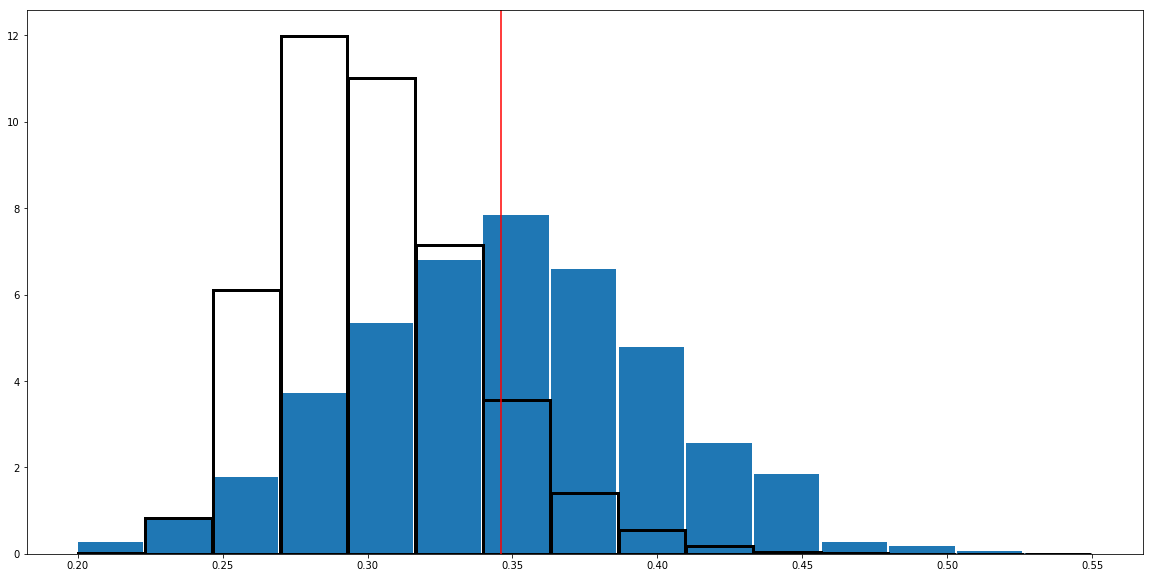

In [10]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
bins = np.linspace(0.20, 0.55, 16)
ax.hist(df_sims.loc[df_sims['player'] == 2, 'avg_sim'], bins, width=0.0225, density=True)
ax.hist(df_sims.loc[df_sims['player'] == 2, 'p_hat_JS'], bins, width=0.023, density=True, 
        fc=(1,1,1,0), edgecolor='k', lw=3)
ax.axvline(.346, c='r')